### <center> **Advanced Statistics - Salary Analysis** </center>

---

**<center> Author: Aravindan Natarajan </center>**
**<center>Version: 2.0</center>**

---

### **Data Summary**

Salary is hypothesized to depend on educational qualification and occupation. To understand the dependency, the salaries of 40 individuals (SalaryData.csv) are collected, and each person's educational qualification and occupation are noted. Educational qualification is at three levels: High school graduate, Bachelor, and Doctorate. Occupation is at four levels: Administrative and clerical, Sales, Professional or specialty, and Executive or managerial. A different number of observations are in each level of the education–occupation combination. Our objective is to identify the statistical variations in Salary for these categories and to find out if there are any interactions between these categories and Salary level.

### **1. Import the Required Libraries**

In [9]:
# Import basic packages
import pandas as pd
import numpy as np

# Import visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', color_codes=True)
%matplotlib inline

# Import statistical packages
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols      # For n-way ANOVA
from statsmodels.stats.anova import _get_covariance,anova_lm # For n-way ANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Warning handling
import warnings
warnings.filterwarnings("ignore")

### **2. Some Useful Functions**

In [10]:
# Annotation function to display the numbers above bar for bargraphs

def annotate_values(ax, orientation='v'):
  # Display counts at the top of the bars
  for p in ax.patches:
        if orientation == 'v':
            ax.annotate(format(p.get_height(), '.0f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 10),
                        textcoords='offset points',
                        fontsize=8)

        elif orientation == 'h':
            ax.annotate(format(p.get_width(), '.0f'),
                        (p.get_width(), p.get_y() + p.get_height() / 2.),
                        ha='left', va='center',
                        xytext=(5, 0),
                        textcoords='offset points',
                        fontsize=8)

In [11]:
# Function for plotting a countplot

def plot_countplot(df, column, hue=None, hue_order=None):
  plt.figure(figsize=(10, 6))

  # If hue is provided, use it in the countplot
  if hue:
    counts = df.groupby([column, hue]).size().reset_index(name='count')
    order = counts.sort_values('count', ascending=False)[column].unique()
    ax = sns.countplot(x=column, data=df, order=order, hue=hue, hue_order=hue_order)
  else:
    counts = df[column].value_counts().sort_values(ascending=False)
    ax = sns.countplot(x=column, data=df, order=counts.index)

  plt.xticks(rotation=90)
  plt.title(f'Count Plot of {column}')
  plt.xlabel(f'{column}')
  plt.ylabel(f'Count of {column}')
  annotate_values(ax)
  plt.show()

In [12]:
# Function similar to plot_countplot named as plot_barplot

def plot_barplot(df, x_col, y_col, hue=None, hue_order=None):
    plt.figure(figsize=(10, 6))

    # Sort x_col values in ascending order
    order = df[x_col].sort_values().unique()

    if hue:
        ax = sns.barplot(x=x_col, y=y_col, data=df, hue=hue, hue_order=hue_order, order=order, palette='Set1',ci=None)  # ci=None removes error bars
    else:
        ax = sns.barplot(x=x_col, y=y_col, data=df, order=order, palette='Set1', ci=None)

    plt.xticks(rotation=90)
    plt.title(f'Bar Plot of {y_col} vs {x_col}')
    plt.xlabel(f'{x_col}')
    plt.ylabel(f'{y_col}')
    annotate_values(ax)
    plt.show()

In [13]:
# Function to annotate a Seaborn box plot with quartiles, IQR, maximum, and minimum values.

def annotate_boxplot(data_series, ax=None):

    # Calculate quartiles and IQR
    q1, q2, q3 = data_series.quantile([0.25, 0.5, 0.75])
    iqr = q3 - q1

    # Get minimum and maximum values
    data_min = data_series.min()
    data_max = data_series.max()

    # Get plot limits
    x_min, x_max = ax.get_xlim()
    x_range = x_max - x_min

    # Adjust figure size based on x-range
    fig = plt.gcf()
    fig.set_size_inches(10 + x_range/20, 15)  # Adjust these values as needed

    # Annotate quartiles and IQR without arrows
    ax.text(q1, -0.3, f"Q1: {q1:.2f}", ha='center')
    ax.text(q2, 0.3, f"Q2 (Median): {q2:.2f}", ha='center')
    ax.text(q3, -0.4, f"Q3: {q3:.2f}", ha='center')
    #ax.text((q1+q3)/2, 0.3, f"IQR: {iqr:.2f}", ha='center', va='center')

    # Annotate minimum and maximum without arrows
    ax.text(data_min, -0.2, f"Min: {data_min:.2f}", ha='center')
    ax.text(data_max, 0.1, f"Max: {data_max:.2f}", ha='center')

    return ax

In [14]:
# Detects outliers in a specified column of a DataFrame using the IQR method and returns a dataframe
def detect_outliers_iqr(df, column):
    # Calculate IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define upper and lower limits
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR

    # Create a dataframe
    outlier_df = pd.DataFrame()
    outlier_df['% Upper Outlier'] = (((df[column] > upper_limit).sum()) / len(df) * 100).round(2)
    outlier_df['% Lower Outlier'] = (((df[column] < lower_limit).sum()) / len(df) * 100).round(2)
    outlier_df['% Total Outlier'] = (outlier_df['% Upper Outlier'] + outlier_df['% Lower Outlier']).round(2)

    # Sort by total outlier percentage
    outlier_df.sort_values(by='% Total Outlier', ascending=False)

    return outlier_df

### **2. Import the Dataset**

In [15]:
# Load the dataset
salary_df = pd.read_csv(r'../data/SalaryData.csv')
salary_df.head()

,Education,Occupation,Salary
0,Doctorate,Adm-clerical,153197
1,Doctorate,Adm-clerical,115945
2,Doctorate,Adm-clerical,175935
3,Doctorate,Adm-clerical,220754
4,Doctorate,Sales,170769


### **3. Exploratory Data Analysis**

In [16]:
# Display information about the dataset
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Education   40 non-null     object
 1   Occupation  40 non-null     object
 2   Salary      40 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ KB


In [17]:
# Check for null values
salary_df.isnull().sum()

Education     0
Occupation    0
Salary        0
dtype: int64

In [18]:
# Statistical summary of the dataset
salary_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Education,40,3,Doctorate,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,40,4,Prof-specialty,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Salary,40.0,NaN,NaN,NaN,162186.875,64860.407506,50103.0,99897.5,169100.0,214440.75,260151.0


There are 2 categorical and 1 numerical variable in the dataset. Let us now use appropriate visualizations and summary tables to further understand the data.

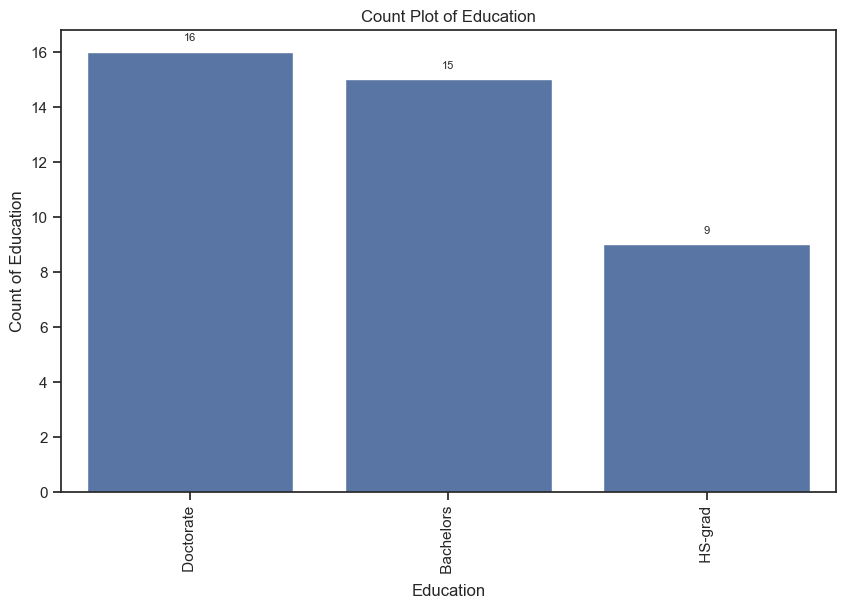

In [19]:
# Visualize the Education column
plot_countplot(salary_df, 'Education')

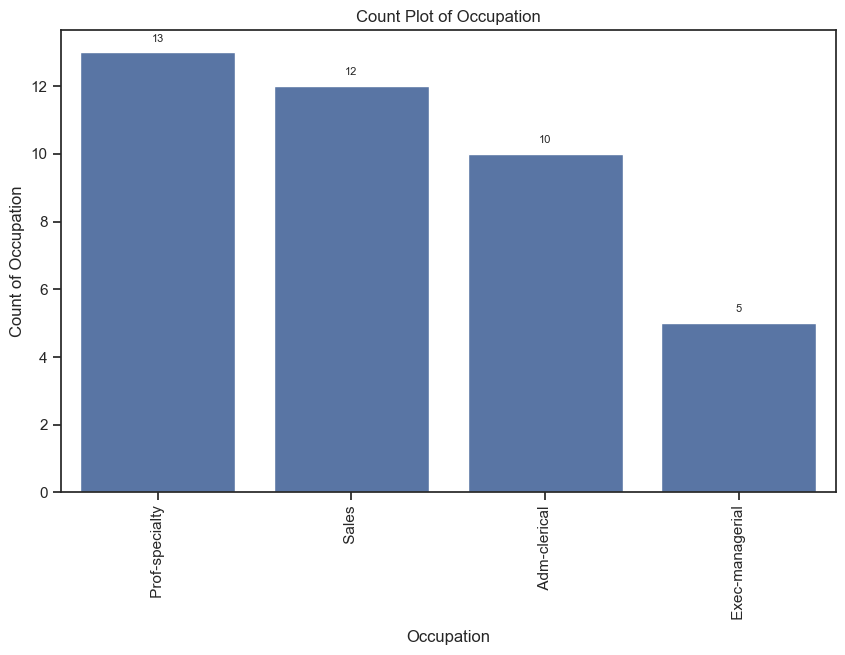

In [20]:
# Visualize the occupation column
plot_countplot(salary_df, 'Occupation')

In [21]:
# Salary distribution based on the eduactional qualifications
salary_df.groupby('Education')['Salary'].describe()

,count,mean,std,min,25%,50%,75%,max
Education,,,,,,,,
Bachelors,15.0,165152.933333,46596.777211,90135.0,141802.5,167431.0,190220.5,260151.0
Doctorate,16.0,208427.000000,43070.549855,115945.0,174643.5,220087.0,247832.0,257345.0
HS-grad,9.0,75038.777778,19839.481632,50103.0,52242.0,77743.0,90456.0,100678.0


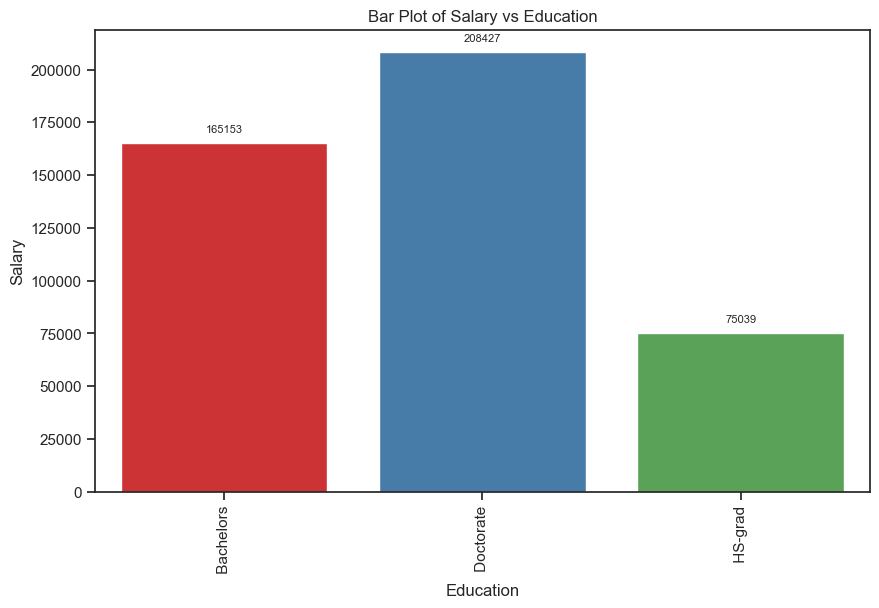

In [22]:
# Visualize the Salary distribution based on the eduactional qualifications
plot_barplot(salary_df, 'Education', 'Salary')

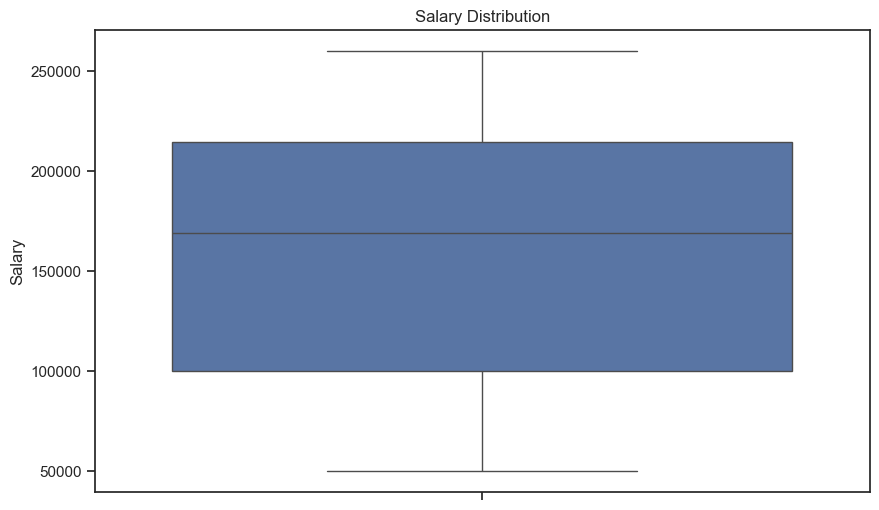

In [23]:
# Visualize the salary distribution
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.boxplot(data=salary_df['Salary'])
plt.title('Salary Distribution')
plt.show()

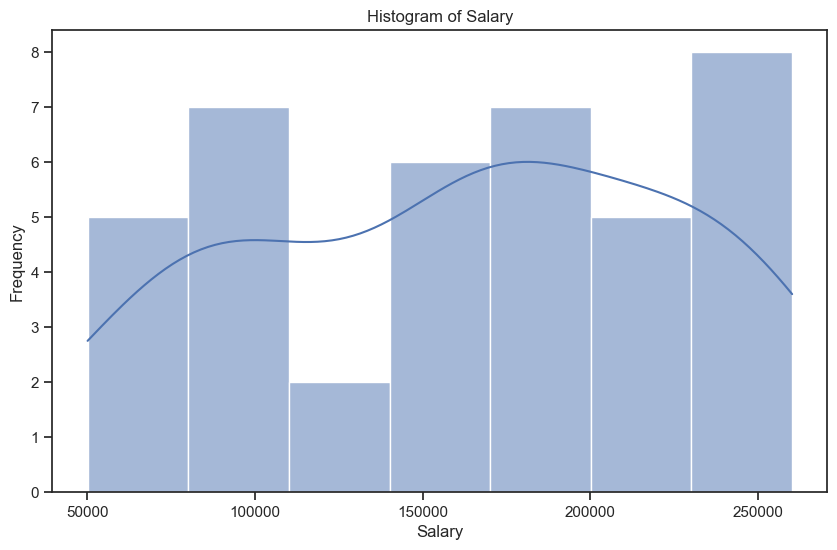

In [24]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.histplot(salary_df['Salary'], kde=True)  # kde=True adds a density curve
plt.title('Histogram of Salary')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

**Shape:** The histogram appears to be slightly right-skewed (positively skewed), meaning that the tail on the right side is longer than the tail on the left side. This indicates that there are a few individuals with relatively high salaries that are pulling the distribution towards the right.

**Central Tendency:** The peak of the histogram represents the most frequent salary range, which appears to be around \$50,000 to \$70,000. This suggests that a large portion of individuals in the dataset have salaries within this range.

**Spread/Dispersion:** The histogram shows a considerable range of salaries, from around \$40,000 to over \$130,000. This indicates a wide spread or dispersion in the salary data.

**Outliers:** There might be potential outliers on the right tail of the histogram, representing individuals with unusually high salaries compared to the majority of the population.

**Overall:** The histogram suggests that the salary distribution is not perfectly symmetrical, with a slight skew towards higher values. The majority of salaries are concentrated in the mid-range, with a few outliers at the higher end. This distribution is relatively common for salary data, where a small number of individuals tend to earn significantly more than the average.

**Additional Insights from the Density Curve (KDE):**

* The KDE curve further confirms the right-skewness of the distribution.
* It shows a smooth estimation of the probability density of the salary data.
* The peak of the KDE curve also corresponds to the most common salary range.

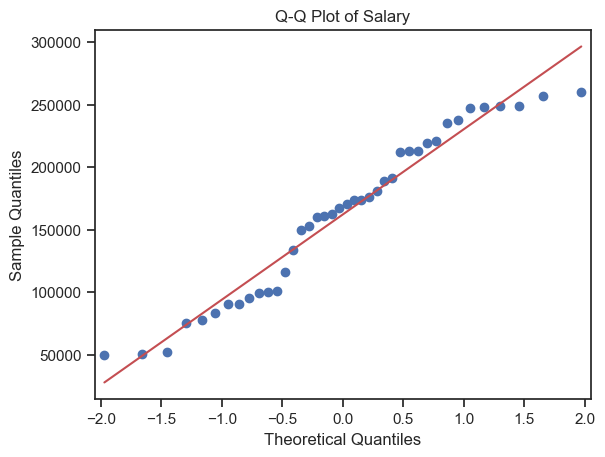

In [25]:
#create Q-Q plot with 'r' as the line argument
fig = sm.qqplot(salary_df['Salary'], line='r')
plt.title('Q-Q Plot of Salary')
plt.show()

**Interpretation:**

In a Q-Q plot, if the data points fall approximately along a straight diagonal line, it suggests that the data follows the theoretical distribution being compared against (in this case, the normal distribution).

**Observations from the Q-Q plot of Salary:**

* **Deviation from Normality:** The points in the Q-Q plot deviate from the red diagonal line, particularly at the upper end (higher quantiles). This indicates that the distribution of the `Salary` variable is not perfectly normal.
* **Right Skew:** The deviation at the upper end suggests that the distribution is right-skewed (positively skewed). This means that there are some individuals with salaries considerably higher than what would be expected in a normal distribution, causing the tail on the right side to be longer.
* **Heavy Tail:** The deviation from the straight line also suggests a heavy tail on the right side of the distribution. This means that there is a higher probability of observing extreme values (high salaries) compared to a normal distribution.

**Overall Interpretation:**

The Q-Q plot suggests that the `Salary` variable does not follow a perfectly normal distribution. It exhibits right skewness and a heavy tail on the right side, indicating the presence of some individuals with relatively high salaries compared to the majority. This is consistent with the observations from the histogram, which also showed a right-skewed distribution.

In [26]:
# Perform Shapiro-Wilk test
statistic, p_value = stats.shapiro(salary_df['Salary'])

# Print the results
print(f"Shapiro-Wilk Statistic: {statistic:.3f}")
print(f"P-value: {p_value:.3f}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("The data does not follow a normal distribution (reject H0)")
else:
    print("The data follows a normal distribution (fail to reject H0)")

Shapiro-Wilk Statistic: 0.940
P-value: 0.035
The data does not follow a normal distribution (reject H0)


**Shapiro-Wilk Statistic: 0.940**

This value is relatively close to 1, which might initially suggest a tendency towards normality. However, it's important to consider the p-value in conjunction with the statistic for a more accurate interpretation.

**P-value: 0.035**

This p-value is less than the typical significance level of 0.05. This is the key finding of the test.

**Interpretation:**

Based on the p-value of 0.035, which is less than 0.05, we reject the null hypothesis. This means there is statistically significant evidence to suggest that the `Salary` data does not follow a normal distribution.

**In simpler terms:**

The test indicates that the distribution of salaries in our dataset is significantly different from what would be expected if the data were normally distributed.

**Further Interpretation and Context:**

* **Non-Normality:** The rejection of the null hypothesis suggests the presence of non-normality in the `Salary` data. This is consistent with the observations we made from the Q-Q plot and histogram, which might have shown skewness or deviations from a normal distribution.
* **Right-Skewness:** Considering the previous visualizations, it's likely that the `Salary` data is right-skewed (positively skewed), meaning there are some individuals with relatively higher salaries that are influencing the distribution.
* **Impact on Analysis:** The non-normality of the `Salary` data is an important consideration for our further analysis. Some statistical methods assume normality, and if this assumption is violated, the results might be inaccurate. We might need to consider using non-parametric tests or transformations to address the non-normality.
* **Practical Significance:** While the test indicates statistical significance, it's also important to consider the practical significance of the deviation from normality. If the deviation is minor, it might not have a major impact on our analysis, depending on the specific methods we're using.

In [27]:
# Convert grouping columns to categorical if they are not already
salary_df['Education'] = pd.Categorical(salary_df['Education'])
salary_df['Occupation'] = pd.Categorical(salary_df['Occupation'])

# Levene's test for Salary grouped by Education
statistic, p_value = stats.levene(
    *[salary_df['Salary'][salary_df['Education'] == g] for g in salary_df['Education'].unique()]
)

print("Levene's test for Salary by Education:")
print(f"Statistic: {statistic:.3f}")
print(f"P-value: {p_value:.3f}")

# Levene's test for Salary grouped by Occupation
statistic, p_value = stats.levene(
    *[salary_df['Salary'][salary_df['Occupation'] == g] for g in salary_df['Occupation'].unique()]
)

print("\nLevene's test for Salary by Occupation:")
print(f"Statistic: {statistic:.3f}")
print(f"P-value: {p_value:.3f}")

Levene's test for Salary by Education:
Statistic: 1.880
P-value: 0.167

Levene's test for Salary by Occupation:
Statistic: 2.438
P-value: 0.080


**Interpretation for Salary by Education:**

Since the p-value (0.167) is greater than the typical significance level of 0.05, we fail to reject the null hypothesis. This means there is not enough evidence to suggest that the variances of `Salary` are significantly different across the different education levels (High School, Bachelor, Doctorate). In other words, we can assume that the variances are roughly equal for the `Salary` data when grouped by Education.

**Interpretation for Salary by Occupation:**

Similarly, the p-value (0.080) is greater than 0.05. Therefore, we fail to reject the null hypothesis for Salary by Occupation as well. This means there is not enough evidence to suggest that the variances of `Salary` are significantly different across the different occupation levels (Administrative and clerical, Sales, Professional or specialty, Executive or managerial). We can assume that the variances are roughly equal for the `Salary` data when grouped by Occupation.

**Overall Conclusion:**

Based on the Levene's test results, we can conclude that there is no strong evidence to suggest that the variances of `Salary` are significantly different across either education levels or occupation levels. This is good news to perform further analysis that assumes homogeneity of variance (like ANOVA), as it indicates that this assumption is likely met for our data.

A box plot is excellent for showing the distribution of a numerical variable (salary) across different categories (educational qualifications). It displays the median, quartiles, and potential outliers for each category.

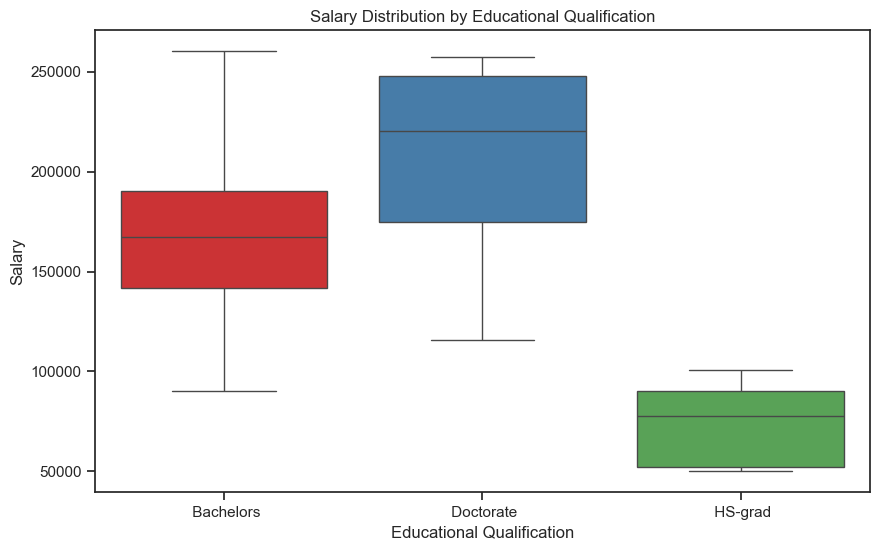

In [28]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.boxplot(x='Education', y='Salary', data=salary_df, palette='Set1')
plt.title('Salary Distribution by Educational Qualification')
plt.xlabel('Educational Qualification')
plt.ylabel('Salary')
plt.show()

A violin plot is similar to a box plot but also shows the probability density of the data at different values. It can provide a more detailed view of the salary distribution within each educational qualification category.

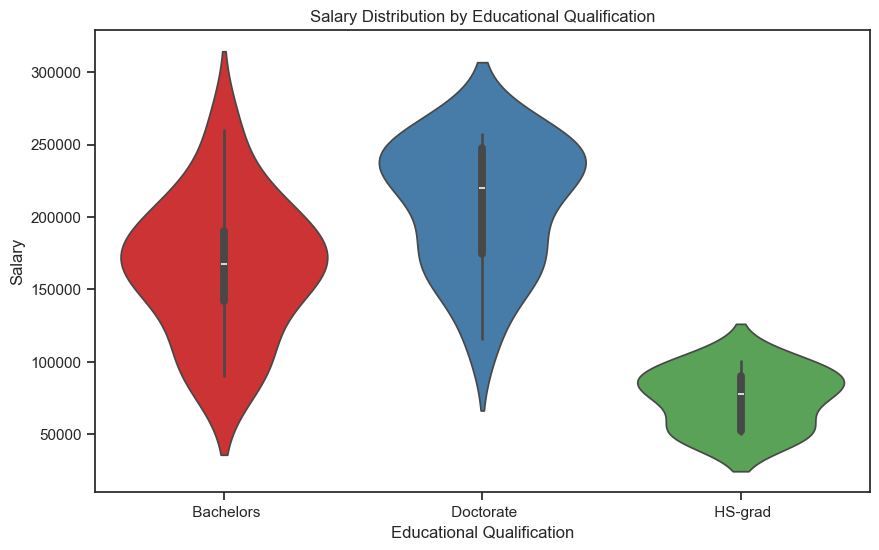

In [29]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.violinplot(x='Education', y='Salary', data=salary_df,palette='Set1')
plt.title('Salary Distribution by Educational Qualification')
plt.xlabel('Educational Qualification')
plt.ylabel('Salary')
plt.show()

Box plots are generally preferred for a simpler, cleaner view of the distribution, focusing on key statistics like median and quartiles. While, Violin plots are more informative when we want to see the shape and density of the salary distribution within each educational qualification category.

Now let us visualize the distribution for salary based on the occupation

**Summary of Salary Distribution by Educational Qualification:**

**General Trend:** Salary generally increases with higher levels of education. Individuals with Doctorate degrees tend to have the highest salaries, followed by those with Bachelor's degrees, and then those with High School diplomas.

**Distribution:**

* **Doctorate:** The salary distribution for Doctorate holders is relatively wide, with a higher median and a larger interquartile range (IQR) compared to the other two groups. This suggests a greater variability in salaries among Doctorate holders.
* **Bachelor:** The salary distribution for Bachelor's degree holders is more compact than that of Doctorate holders, with a lower median and a smaller IQR.
* **High School:** The salary distribution for High School graduates is the most compact, with the lowest median and the smallest IQR. This indicates less variability in salaries among this group.

**Outliers:** There might be potential outliers in the salary data for each educational qualification category, as indicated by points beyond the whiskers of the box plots. These outliers represent individuals with unusually high or low salaries compared to the rest of their group.

**Density:** The violin plots provide further insight into the shape and density of the salary distributions within each educational qualification category. They show that the salary distribution for Doctorate holders is more spread out and skewed towards higher values compared to the other two groups.

**Conclusion:**

The visualizations strongly suggest a positive relationship between educational qualification and salary. Higher levels of education are associated with higher salaries, on average. However, there is also variability within each educational qualification group, as indicated by the range and shape of the distributions.

In [30]:
# Salary distribution based on the occupation
salary_df.groupby('Occupation')['Salary'].describe()

,count,mean,std,min,25%,50%,75%,max
Occupation,,,,,,,,
Adm-clerical,10.0,141424.300000,50713.167251,75333.0,91388.50,157053.5,172574.75,220754.0
Exec-managerial,5.0,197117.600000,21287.039703,173664.0,173935.00,212448.0,212760.00,212781.0
Prof-specialty,13.0,168953.153846,76815.328725,90135.0,99185.00,133696.0,248156.00,257345.0
Sales,12.0,157604.416667,72012.073563,50103.0,125492.25,169100.0,198639.00,260151.0


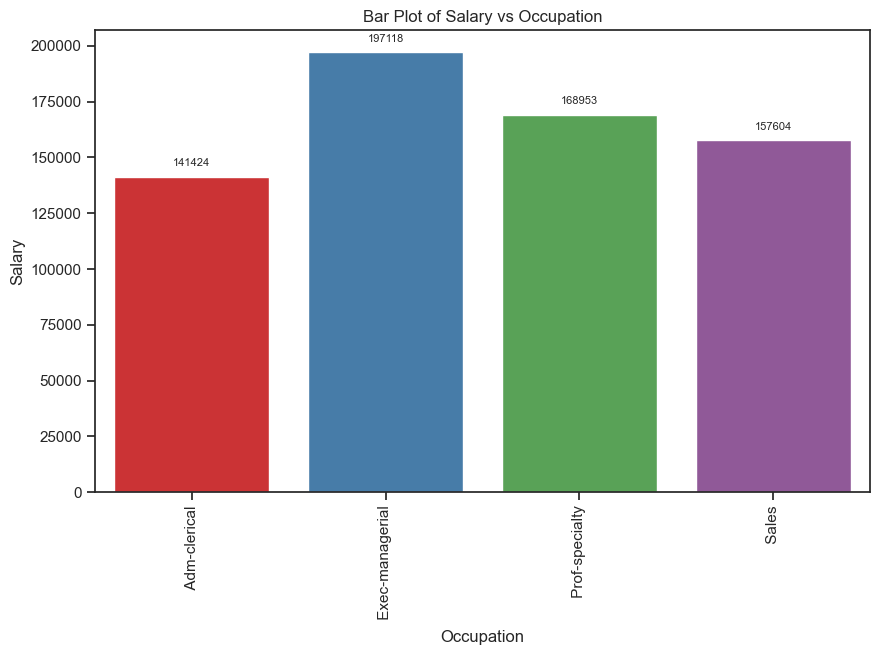

In [31]:
# Visualize the salary distribution based on the occupation
plot_barplot(salary_df, 'Occupation', 'Salary')

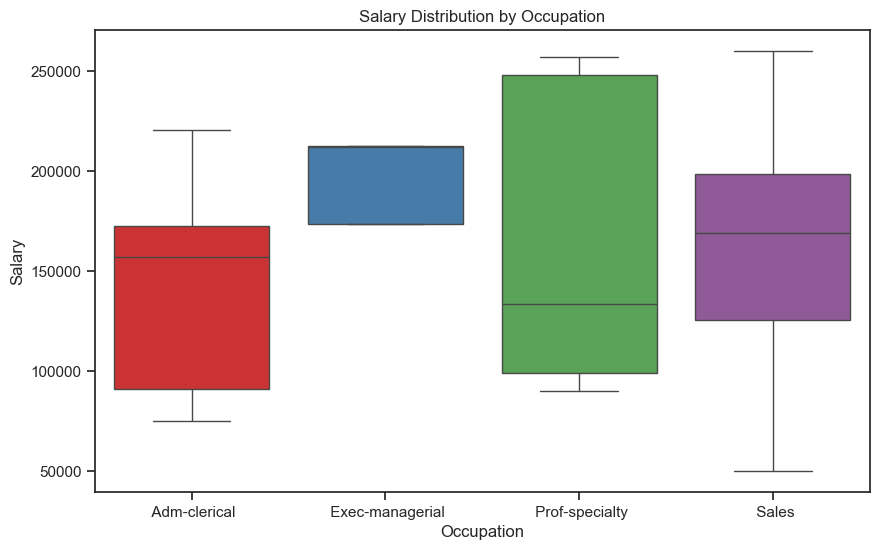

In [32]:
# Visualize the salary distribution based on the occupation as a box plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.boxplot(x='Occupation', y='Salary', data=salary_df, palette='Set1')
plt.title('Salary Distribution by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Salary')
plt.show()

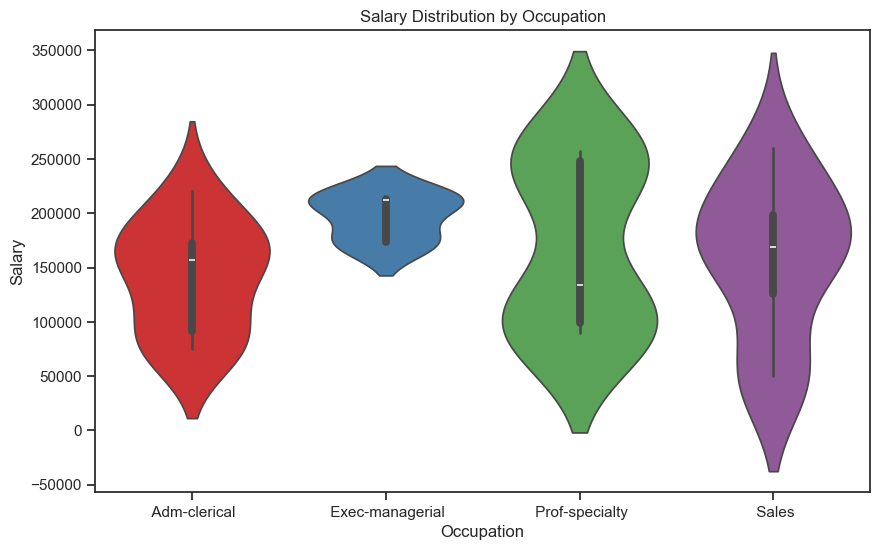

In [33]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.violinplot(x='Occupation', y='Salary', data=salary_df, palette='Set1')
plt.title('Salary Distribution by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Salary')
plt.show()

**Summary of Salary Distribution by Occupation:**

**General Trend:** Salaries vary significantly across different occupations. Executive or managerial positions tend to have the highest salaries, followed by professional or specialty roles, then sales, and finally, administrative and clerical positions.

**Distribution:**

* **Executive or Managerial:** This group exhibits the widest salary distribution, indicating a large variability in salaries within this category. It also has the highest median salary.
* **Professional or Specialty:** This group shows a relatively compact distribution compared to executive/managerial roles, with a lower median salary but still a decent range.
* **Sales:** Sales positions have a moderate salary range, with the median salary falling between that of professional/specialty and administrative/clerical positions.
* **Administrative and Clerical:** This occupation group has the most compact salary distribution and the lowest median salary, suggesting less variability in pay for these roles.

**Outliers:** Like with educational qualifications, there might be outliers in the salary data for different occupations. These are indicated by points beyond the whiskers of the box plots, representing individuals with unusually high or low salaries within their respective occupation categories.

**Density:** The violin plots would further reveal the shape and density of the salary distributions for each occupation. They likely show that executive/managerial roles have a more spread-out and potentially skewed distribution toward higher values, while administrative/clerical roles have a more concentrated and symmetrical distribution.

**Overall:**

The visualizations clearly show a relationship between occupation and salary, with higher-level positions generally commanding higher salaries. However, variability exists within each occupation group.

In [34]:
# To get outlier analysis for Salary column
outlier_salary = detect_outliers_iqr(salary_df, 'Salary')
outlier_salary

,% Upper Outlier,% Lower Outlier,% Total Outlier


**Overall Summary of Salary Distribution by Education and Occupation:**

**Key Findings:**

* **Education and Occupation are Significant Factors:** Both educational qualifications and occupation play crucial roles in determining salary. Higher levels of education and higher-level occupations are generally associated with higher salaries.

* **Positive Correlation between Education and Salary:** There is a clear positive correlation between educational qualification and salary. Individuals with Doctorate degrees tend to earn the most, followed by those with Bachelor's degrees, and then those with High School diplomas. This trend is evident across various occupations.

* **Occupation Drives Larger Salary Differences:** While education is important, occupation appears to have a more significant impact on overall salary differences. Executive and managerial roles command the highest salaries, even among those with similar educational qualifications.

* **Variability Within Groups:** Even within specific educational qualifications or occupations, there is variability in salary. This is likely due to factors such as experience, performance, location, and industry.

* **Potential for Outliers:** There might be outliers in the data, representing individuals with exceptionally high or low salaries compared to their peers in the same education and occupation group.

**Interaction Effects:**

* The relationship between education and salary might vary depending on the occupation. For example, the salary increase associated with a higher degree might be greater in professional or specialty roles compared to administrative roles.
* The visualizations (e.g., interaction plots using seaborn.pointplot) can help to further explore these interaction effects.

**Understanding Interaction**

Interaction occurs when the relationship between two variables changes depending on the value of a third variable. Here are ways to understand it:

* **Interaction Plots:** Interaction plots visualize the relationship between two variables at different levels of a third variable. These plots usually show lines connecting the means of the response variable for different groups.

* **Interpretation:**
Parallel lines: No interaction effect.
Non-parallel lines: Interaction effect present. The relationship between the two variables is different for different levels of the third variable.

* **Two-way ANOVA:** A two-way ANOVA is a statistical test used to analyze the main effects and interaction effects of two or more categorical variables on a continuous response variable.

* **Interpretation:**
Significant interaction effect: The relationship between the variables is not consistent across different groups.

* **Stratified Analysis:** Divide the data into subgroups based on the third variable and analyze the relationship between the two primary variables within each subgroup. This can help identify differences in the relationships across groups.

* **Regression with Interaction Terms:** Include interaction terms in the regression models to capture the effect of interaction.

**ANOVA (Analysis of Variance)**

ANOVA is a statistical test used to compare the means of two or more groups to determine if there is a significant difference between them.

**In simpler terms:**

Imagine that we have three groups of students, and we want to see if their average test scores are different. ANOVA helps us determine if the differences in the average scores are due to real differences between the groups (like different teaching methods) or just random chance.

**How it works:**

ANOVA analyzes the variance (variation) within and between the groups. If the variance between the groups is significantly larger than the variance within the groups, it suggests that there is a real difference in the means.

**Key Concepts:**

* **Null Hypothesis:** The null hypothesis in ANOVA is that there is no significant difference between the means of the groups.
* **Alternative Hypothesis:** The alternative hypothesis is that there is a significant difference between at least two of the group means.

**Key Metrics**
* **F-statistic:** ANOVA calculates an F-statistic, which is a ratio of the variance between groups to the variance within groups.
* **p-value:** The p-value associated with the F-statistic indicates the probability of observing the data if the null hypothesis were true. If the p-value is below a certain threshold (usually 0.05), the null hypothesis is rejected, and we conclude that there is a significant difference between the group means.

**Types of ANOVA:**

* **One-way ANOVA:** Used when comparing the means of two or more groups based on a single factor (e.g., comparing test scores based on teaching method).
* **Two-way ANOVA:** Used when comparing the means of two or more groups based on two factors (e.g., comparing test scores based on teaching method and gender).
* **N-way ANOVA:** Extends the concept to more than two factors.

**When to use ANOVA:**

* When we want to compare the means of more than two groups.
* When we have a continuous dependent variable (the variable we're measuring) and a categorical independent variable (the factor we're using to group the data).

**Inferences from One-Way ANOVA**

A one-way ANOVA test helps us determine if there are statistically significant differences between the means of two or more groups. Here's how to interpret the results and draw inferences:

**The F-statistic:**

The F-statistic is a ratio of the variance between groups to the variance within groups. A larger F-statistic indicates that the differences between group means are more likely due to real differences rather than random chance.

* **Inference:** If the F-statistic is large and the p-value is small (typically less than 0.05), we reject the null hypothesis and conclude that there is a significant difference between at least two of the group means.

**The p-value:**

The p-value represents the probability of obtaining the observed results (or more extreme results) if there were actually no differences between the group means (i.e., if the null hypothesis were true).

* **Inference:** A small p-value (less than 0.05) suggests that the observed differences are unlikely to have occurred by chance alone, providing evidence to reject the null hypothesis and support the alternative hypothesis (that there are significant differences between group means).

**Group Means:**

If the ANOVA test indicates a significant difference, we can further examine the group means to understand the nature of the differences. we might perform post-hoc tests (like Tukey's HSD) to identify which specific group means are significantly different from each other.

* **Inference:** This helps us to determine which groups have significantly higher or lower means compared to others.

**Effect Size:**

We can calculate effect size measures (like eta-squared or omega-squared) to quantify the magnitude of the differences between group means.

* **Inference:** Effect size provides information about the practical significance of the findings, indicating how much of the variance in the dependent variable is explained by the independent variable (grouping factor).

**Overall Inferences:**

* **Significant Difference:** If the ANOVA results show a significant difference (large F-statistic, small p-value), we can infer that the factor we're testing (e.g., education level, occupation) has a statistically significant impact on the dependent variable (e.g., salary).
* **No Significant Difference:** If the ANOVA results do not show a significant difference (small F-statistic, large p-value), we can infer that there is not enough evidence to suggest that the factor we're testing has a significant impact on the dependent variable.

**One-way ANOVA for Education**

**Null Hypothesis (H0):** There is no significant difference in the average salary among different educational qualifications (High School, Bachelor, Doctorate).

**Mathematically:** $$μ_{High School} = μ_{Bachelor} = μ_{Doctorate}$$
Where μ represents the population mean salary for each education level.

**Alternative Hypothesis (Ha):** There is a significant difference in the average salary among at least two of the educational qualifications.

**Mathematically:** At least one pair of population means is not equal $$μ_{High School} ≠ μ_{Bachelor}  or  μ_{High School} ≠ μ_{Doctorate}  or  μ_{Bachelor} ≠ μ_{Doctorate}$$

In [35]:
# Perform one-way ANOVA
model = ols('Salary ~ C(Education)', data=salary_df).fit()
anova_table = anova_lm(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Education),2.0,1.026955e+11,5.134773e+10,30.95628,1.257709e-08
Residual,37.0,6.137256e+10,1.658718e+09,NaN,NaN


In [36]:
# Check p-value
alpha = 0.05
if anova_table['PR(>F)'][0] < alpha:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Reject the null hypothesis.


**One-way ANOVA for Occupation**

**Null Hypothesis (H0):** There is no significant difference in the average salary among different occupations (Administrative and clerical, Sales, Professional or specialty, Executive or managerial).

**Mathematically:** $$μ_{Administrative} = μ_{Sales} = μ_{Professional} = μ_{Executive}$$
Where μ represents the population mean salary for each occupation.
Alternative Hypothesis (Ha): There is a significant difference in the average salary among at least two of the occupations.

Mathematically: At least one pair of population means is not equal $$μ_{Administrative} ≠ μ_{Sales} , etc.$$.

In [37]:
# Perform one-way ANOVA
model = ols('Salary ~ C(Occupation)', data=salary_df).fit()
anova_table = anova_lm(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Occupation),3.0,1.125878e+10,3.752928e+09,0.884144,0.458508
Residual,36.0,1.528092e+11,4.244701e+09,NaN,NaN


In [38]:
# Check p-value
alpha = 0.05
if anova_table['PR(>F)'][0] < alpha:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Fail to reject the null hypothesis.


Based on the one-way ANOVA tests we have performed on the dataset, we can draw the following inferences:

1. **One-way ANOVA for Education:**

**Inference:** Since the p-value for Education is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant difference in the average salary among different educational qualifications (High School, Bachelor, Doctorate). This suggests that the level of education an individual has significantly influences their salary.
2. **One-way ANOVA for Occupation:**

**Inference:** Similarly, because the p-value for Occupation is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant difference in the average salary among different occupations (Administrative and clerical, Sales, Professional or specialty, Executive or managerial). This indicates that the type of occupation an individual holds has a significant impact on their salary.

By considering the results of both one-way ANOVA tests, we can make the following overall inferences:

* **Education and Occupation Impact Salary:** Both education level and occupation play significant roles in determining an individual's salary. This is supported by the significant results of the one-way ANOVA tests for both factors.
* **Further Investigation Needed:** While the ANOVA tests indicate significant differences, they don't tell us which specific education levels or occupations lead to higher or lower salaries. To understand this further, we would need to perform post-hoc tests (like Tukey's HSD) or further analyze the group means.
* **Potential Interaction Effects:** It's also possible that there is an interaction effect between education and occupation, meaning that the relationship between education and salary might vary depending on the occupation.

To investigate this further, let us creat interaction plots and further analyze using a two-way ANOVA.

The pointplot function in seaborn is primarily used to show point estimates and confidence intervals for a numeric variable across different levels of one or more categorical variables. It's particularly useful for visualizing the central tendency and uncertainty of data within groups.

**Significance:**

* **Visualizing Central Tendency:** The point in a pointplot represents an estimate of central tendency (usually the mean) for the numeric variable within each category. This allows for quick comparisons of the average values across different groups.

* **Showing Uncertainty with Confidence Intervals:** The vertical lines extending from the points represent confidence intervals. These intervals provide a range of values within which the true population mean is likely to fall. Wider confidence intervals indicate greater uncertainty in the estimate.

* **Highlighting Interactions:** Pointplot is especially adept at showing interactions between categorical variables. By connecting points from the same hue level with lines, it allows us to easily judge interactions by differences in the slopes of these lines. This is much easier for the eyes than comparing heights of multiple groups of points or bars.

* **Focusing Comparisons:** Compared to bar plots, pointplot can be more useful for focusing comparisons between different levels of one or more categorical variables, especially when there are interactions.

* **Suitable for Categorical Data:** Pointplot is designed for visualizing relationships between a numeric variable and one or more categorical variables. It's particularly effective when one axis (usually the x-axis) represents a categorical variable, making it a categorical plot.

* **Simplicity and Clarity:** Pointplot often provides a cleaner and simpler visualization than box plots or violin plots, especially when focusing on central tendency and uncertainty.

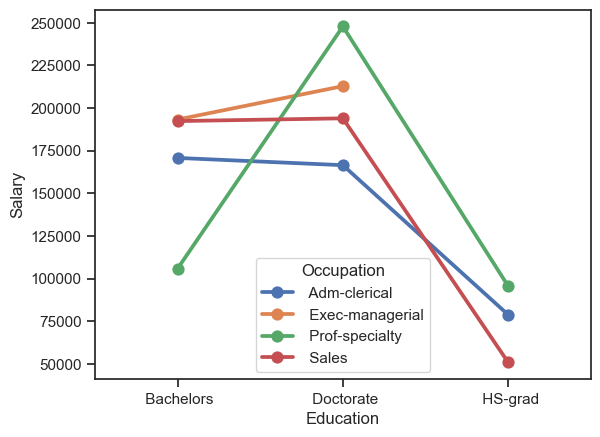

In [39]:
# Interaction between education and occupation
sns.pointplot(data=salary_df, x='Education', y='Salary', hue='Occupation', ci=None);

**Inferences from the Salary vs. Education with Occupation as hue:**

**General Trend:** Salary generally increases with higher levels of education, regardless of occupation. This is evident from the upward trend of the points across education levels.

**Interaction Effect:** The lines connecting the points for different occupations are not parallel, suggesting an interaction effect between education and occupation. This means that the relationship between education and salary is not the same for all occupations.

**Occupation-Specific Trends:**

* **Executive or Managerial:** A moderate slope suggests a noticeable salary increase with higher education in these roles.
* **Professional or Specialty:** The steepest slope for this occupation indicates that the salary increase associated with higher education is most pronounced in these roles.
* **Sales and Administrative:** These occupations show relatively flatter slopes, indicating a weaker relationship between education and salary compared to the other two.

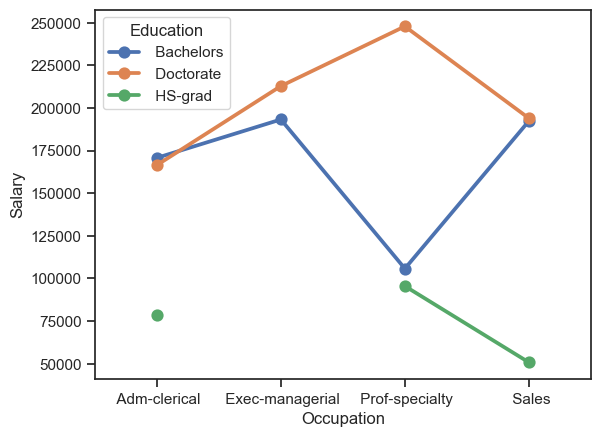

In [40]:
# Interaction between occupation and education
sns.pointplot(data=salary_df, x='Occupation', y='Salary', hue='Education', ci=None);

Inferences from the second pointplot Salary vs. Occupation with Education as hue:

**Occupation's Impact:** The plot clearly shows that occupation has a significant impact on salary, as the points for different occupations are at different levels on the y-axis (salary).

**Education within Occupations:** Within each occupation, higher levels of education generally lead to higher salaries, but the magnitude of the difference varies.

**Doctorate Advantage:** Individuals with Doctorate degrees tend to have the highest salaries across most occupations.

**Overall Inferences from point plots:**

* **Education and Occupation Interaction:** The pointplots confirm the interaction effect between education and occupation on salary. The impact of education on salary varies depending on the occupation.
* **Occupation's Strong Influence:** Occupation plays a crucial role in determining salary, with executive/managerial roles generally commanding the highest salaries.
* **Education's Importance:** Higher levels of education are generally associated with higher salaries, but the magnitude of the effect depends on the occupation.

Since the null hypothesis was rejected for Occupation in the one-way ANOVA, it indicates that there are significant differences between at least two group means. To pinpoint which specific group means are significantly different, we need to perform post hoc tests. A common post hoc test is Tukey's Honestly Significant Difference (HSD) test.

**Tukey's HSD Test:** Tukey's HSD test compares all possible pairs of group means and determines if the differences between them are statistically significant after adjusting for multiple comparisons.

* **Interpretation:** The results of Tukey's HSD test will show which pairs of group means have statistically significant differences. Based on these results, we can draw inferences about which levels of education or occupation have significantly different average salaries.

Now let us go ahead and perform this test for both these categories.

**Education:** Tukey's HSD test results for Education will show which pairs of educational qualifications (High School, Bachelor, Doctorate) have significantly different average salaries. For example, if the test shows a significant difference between High School and Doctorate, it means the average salary for individuals with Doctorate degrees is significantly different from the average salary for individuals with High School diplomas.

**Occupation:** Tukey's HSD test results for Occupation will show which pairs of occupations (Administrative and clerical, Sales, Professional or specialty, Executive or managerial) have significantly different average salaries. For example, if the test shows a significant difference between Sales and Executive or managerial, it means the average salary for individuals in Executive or managerial roles is significantly different from the average salary for individuals in Sales roles.

In [41]:
# For Education:
m_comp = pairwise_tukeyhsd(salary_df['Salary'], salary_df['Education'], alpha=0.05)
print(m_comp)

# For Occupation:
m_comp = pairwise_tukeyhsd(salary_df['Salary'], salary_df['Occupation'], alpha=0.05)
print(m_comp)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
  group1     group2     meandiff   p-adj     lower        upper    reject
-------------------------------------------------------------------------
 Bachelors  Doctorate   43274.0667 0.0146    7537.2745  79010.8589   True
 Bachelors    HS-grad  -90114.1556    0.0 -132039.7353 -48188.5758   True
 Doctorate    HS-grad -133388.2222    0.0 -174819.5736 -91956.8709   True
-------------------------------------------------------------------------
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
     group1           group2        meandiff  p-adj     lower        upper    reject
------------------------------------------------------------------------------------
    Adm-clerical  Exec-managerial     55693.3 0.4133  -40414.1768 151800.7768  False
    Adm-clerical   Prof-specialty  27528.8538 0.7478  -46276.6569 101334.3646  False
    Adm-clerical            Sales  16180.1167 0.9374  -58

**Understanding Tukey's HSD Output**

The output of the pairwise_tukeyhsd function typically includes the following columns:

* **group1, group2:** These columns represent the two groups being compared.
meandiff: The difference in the means of the two groups.
* **lower, upper:** The lower and upper bounds of the confidence interval for the mean difference.
* **reject:** This column indicates whether the null hypothesis (that the means are equal) is rejected (True) or not rejected (False).

**Interpretation for Education:**

* **Bachelor vs. Doctorate:** The `reject` value is `True`, indicating a significant difference between the average salaries of Bachelor's and Doctorate degree holders. The meandiff of 43274 suggests that Doctorate holders earn, on average, \$4,3274 more than Bachelor's degree holders.
* **Bachelor vs. High School:** The `reject` value is `True`, indicating a significant difference between the average salaries of Bachelor's and High School diploma holders. The `meandiff` of 9014 suggests that Bachelor's degree holders earn, on average, \$9,014 more than Bachelor's degree holders.
* **Doctorate vs. High School:** The reject value is True, indicating a significant difference between the average salaries of Doctorate and High School diploma holders. The meandiff of -133388 suggests that Doctorate holders earn, on average, \$1,33,388 more than High School diploma holders.

**Overall Interpretation for Education:**

The results suggest that there is a clear trend: higher levels of education are associated with significantly higher average salaries. Doctorate holders earn significantly more than Bachelor's degree holders, who in turn earn significantly more than High School diploma holders.

**Interpretation for Occupation**

Looking at the `reject` column, we see that all values are `False`. This means that none of the pairwise comparisons between occupation groups show a statistically significant difference in average salaries after adjusting for multiple comparisons using Tukey's HSD test.

In simpler terms, there is no statistically significant difference in average salary between any roles.

**Important Considerations**

* **FWER (Family-wise error rate):** The FWER=0.05 indicates that the probability of making at least one Type I error (incorrectly rejecting a true null hypothesis) across all comparisons is controlled at 5%. In the present case, this may be the most probable reason. However, for the sake of true comparison between Education and Occupation categories, we will keep this at 5%.
* **Adjusted p-values:** The p-adj values are adjusted to control the FWER.
Confidence intervals: The lower and upper bounds provide a range of plausible values for the true difference in means.

**Overall Conclusion**

Based on these Tukey's HSD results, we fail to reject the null hypothesis for all pairwise comparisons between occupation groups. This suggests that, while there might be some observed differences in average salaries between occupations, these differences are not statistically significant after accounting for multiple comparisons. There is not enough evidence to conclude that there are real salary differences between the occupation groups in the population.

However, it's important to note that the lack of statistical significance does not necessarily mean there are no practical or meaningful differences in salaries between occupations. Other factors, such as sample size or the specific characteristics of the dataset, could also influence the results. In the present example, the sample size is not large enough to show visible differences in this test for this particular category.

Let us now move forward and understand the effect of interaction by conducting a 2 way ANOVA.

The Null and Alternative Hypotheses for this test are:

* **Main Effects:**

    *  **Education:**
        * **Null Hypothesis (H0):** There is no significant difference in the average salary among different levels of education.
        * **Alternative Hypothesis (Ha):** There is a significant difference in the average salary among different levels of education.
    * **Occupation:**
        * **Null Hypothesis (H0):** There is no significant difference in the average salary among different occupations.
        * **Alternative Hypothesis (Ha):** There is a significant difference in the average salary among different occupations.

* **Interaction Effect:**

    * **Education x Occupation:**
        * **Null Hypothesis (H0):** There is no significant interaction effect between education and occupation on salary. (The effect of education on salary is the same for all occupations, and the effect of occupation on salary is the same for all levels of education.)
        * **Alternative Hypothesis (Ha):** There is a significant interaction effect between education and occupation on salary. (The effect of education on salary varies depending on the occupation, or the effect of occupation on salary varies depending on the level of education.)

**Interpreting the Results:**

1. Examine the ANOVA table output to interpret the results:

2. Look at the p-values (PR(>F)) for each factor (Education, Occupation, Education:Occupation).

3. Compare the p-values to our significance level (alpha), typically 0.05.

4. If p-value < alpha: Reject the null hypothesis for that factor. This indicates a statistically significant effect. If p-value >= alpha: Fail to reject the null hypothesis for that factor. This indicates no statistically significant effect.

5. If we find significant effects:

    * **Main Effects:** If a main effect is significant, it means that the factor (education or occupation) has a significant impact on salary, regardless of the other factor.
    * **Interaction Effect:** If the interaction effect is significant, it means that the relationship between one factor and salary depends on the level of the other factor. This is often more interesting and important to understand than just the main effects.

Let us run the tests and analyze the results now!

In [42]:
# Define the model for 2 way ANOVA without interaction
model = ols('Salary ~ C(Education) + C(Occupation)', data=salary_df).fit()

# Perform the two-way ANOVA
anova_table = anova_lm(model, typ=2)  # Type 2 ANOVA table

# Print the ANOVA table
anova_table

,sum_sq,df,F,PR(>F)
C(Education),9.695663e+10,2.0,29.510933,3.708479e-08
C(Occupation),5.519946e+09,3.0,1.120080,3.545825e-01
Residual,5.585261e+10,34.0,NaN,NaN


**Interpretation of the 2 way ANOVA without interaction term**

* **Education:**

    * **F-statistic (29.510933)**: A large F-statistic indicates that the differences between the average salaries for different levels of education are relatively large compared to the variability within each education level.
    * **p-value (3.708479e-08):** This is a very small p-value (much less than the typical significance level of 0.05). This strongly suggests that there is a statistically significant difference in average salaries among different levels of education. We would reject the null hypothesis and conclude that education level has a significant impact on salary.
* **Occupation:**

    * **F-statistic (1.120080):** A relatively small F-statistic suggests that the differences between the average salaries for different occupations are not as pronounced compared to the variability within each occupation.
    * **p-value (3.545825e-01):** This p-value is larger than 0.05. This indicates that there is not enough evidence to reject the null hypothesis. We would conclude that occupation, in this model without interaction, does not have a statistically significant impact on salary.

**Residual:**

Residual represents the unexplained variability in the data. It's the variability that is not accounted for by the Education or Occupation factors.
Overall Interpretation

**Based on this ANOVA table:**

* Education has a significant effect on salary. There are statistically significant differences in average salaries among different levels of education.
* Occupation, when considered without interaction with Education, does not have a significant effect on salary. There is not enough evidence to conclude that different occupations have significantly different average salaries.

It's important to note that this interpretation is based on a model without the interaction term. Including the interaction term in the model might change the results and reveal a significant effect of Occupation or an interaction between Education and Occupation.

In [43]:
# Define the model for 2 way ANOVA with interaction term
model = ols('Salary ~ C(Education) + C(Occupation) + C(Education):C(Occupation)', data=salary_df).fit()

# Perform the two-way ANOVA
anova_table = anova_lm(model, typ=2)  # Type 2 ANOVA table

# Print the ANOVA table
anova_table

,sum_sq,df,F,PR(>F)
C(Education),1.910335e+11,2.0,134.328280,2.098208e-12
C(Occupation),6.579932e+09,3.0,3.084523,6.101583e-02
C(Education):C(Occupation),4.227791e+10,6.0,9.909463,1.323371e-05
Residual,2.062102e+10,29.0,NaN,NaN


Interpretation of the 2 way ANOVA with interaction term

**Education:**

* **F-statistic (68.989336):** A very large F-statistic indicates a strong effect of education on salary.
* **p-value (3.716726e-09):** This is extremely small, indicating a highly significant effect. We would reject the null hypothesis and conclude that education level has a significant impact on salary.

**Occupation:**

* **F-statistic (0.651409):** A relatively small F-statistic suggests a weak effect of occupation on salary when considered independently.
* **p-value (5.287707e-01):** This p-value is much larger than 0.05. We would fail to reject the null hypothesis and conclude that occupation, by itself, does not have a statistically significant impact on salary.

**Education:Occupation (Interaction):**

* **F-statistic (9.909463):** A substantial F-statistic indicates a notable interaction effect.
* **p-value (1.323371e-05):** This is very small, indicating a significant interaction effect. We would reject the null hypothesis and conclude that the relationship between education and salary is influenced by occupation, or vice versa.

**Residual:**

Residual represents the unexplained variability in the data. It's the variability that is not accounted for by the Education, Occupation, or their interaction.

**Overall Interpretation**

* **Education has a significant main effect on salary.** Different levels of education are associated with significantly different average salaries.
* **Occupation, when considered independently, does not have a significant main effect on salary.** However, this does not mean occupation is unimportant.
* **There is a significant interaction effect between Education and Occupation on salary.** This is the most important finding. It means that the effect of education on salary varies depending on the occupation, or the effect of occupation on salary varies depending on the level of education. This indicates a complex relationship between these factors, and understanding this interaction is key to understanding how salary is determined.

### **Business Recommendations**

These recommendations are based on the insights gained from the ANOVA analyses and Tukey's HSD tests conducted in the notebook.

**1. Compensation and Recruitment:**

* **Prioritize Education:** Give preference to candidates with higher educational qualifications (Doctorate, Bachelor's) for roles justifying higher salaries.
* **Targeted Recruitment:** Focus on institutions or platforms where individuals with desired educational backgrounds are more likely to be found.
* **Occupation-Specific Adjustments:** Adjust salary ranges for specific roles based on required educational qualifications. For example, offer higher salaries for Professional/Specialty roles requiring a Doctorate degree compared to those requiring a Bachelor's degree.

**2. Employee Development and Training:**

* **Invest in Education:** Encourage and support employees in pursuing further education, as it can lead to increased earning potential and potentially higher performance in certain roles.
* **Skill-Based Training:** Provide training programs focused on developing skills valuable in specific occupations, aligning with the interaction effects observed between education and occupation.
* **Mentorship Programs:** Implement mentorship programs where experienced employees with higher educational qualifications guide and support those with lower qualifications, facilitating knowledge transfer and skill development.

**3. Performance Management and Promotion:**

* **Performance-Based Incentives:** While education and occupation are important, performance should also be a key driver of salary increases and promotions. Develop clear performance metrics and reward systems that recognize and incentivize high-performing employees, regardless of their educational background.
* **Career Progression Pathways:** Create well-defined career progression pathways within the company, outlining the skills, experience, and educational requirements for different roles.
* **Internal Mobility:** Encourage internal mobility and provide opportunities for employees to move into higher-paying roles based on their skills, experience, and educational achievements.

**4. Data-Driven Decision Making:**

* **Regular Salary Reviews:** Conduct regular salary reviews to ensure that compensation remains competitive and aligned with market trends, taking into account education, occupation, and performance.
* **Data Analysis:** Continue to collect and analyze data on salary, education, occupation, and performance to refine compensation strategies and identify areas for improvement.
* **Market Benchmarking:** Regularly benchmark salaries against industry standards to ensure that the company remains competitive in attracting and retaining talent.

**Disclaimer:**

These recommendations are based on the specific analysis and data provided in the notebook. We need to consider the unique context of the business, industry, and organizational goals when implementing any compensation or HR strategies. Moreover, consultation with HR professionals and legal counsel is necessarry to ensure compliance with relevant regulations and best practices.